# Evaluate AminoAcids Prediction

In [2]:
%matplotlib inline  
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 12.0)

import os

import sys

import numpy as np

from shutil import copyfile

from src.python.aa_predict import *
import src.python.aa_predict  as AA

checkpoint_path = "../../data/trained/aapred_cnn_latest.tar"


emb_dim = 5
win_size = 10

model = GoodOldCNN(emb_dim, win_size)


if os.path.exists(checkpoint_path):
    print("=> loading checkpoint '%s'" % checkpoint_path)
    checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '%s' (epoch %s)" %
          (checkpoint_path, checkpoint['epoch'] + 1))
else:
    print("=> no checkpoint found at '%s'" % checkpoint_path)



=> loading checkpoint '../../data/trained/aapred_cnn_latest.tar'
=> loaded checkpoint '../../data/trained/aapred_cnn_latest.tar' (epoch 8)


### Define Evaluation Function(s)

In [3]:

import torch
import torch.nn as nn

from torch.autograd import Variable

from pymongo import MongoClient


### 1 2 3 Predict...

In [4]:

class_names = sorted(dictionary.keys(), key=lambda aa: dictionary[aa])


client = MongoClient("mongodb://127.0.0.1:27017")
db = client['prot2vec']

global collection_test, size_test, verbose

AA.collection_test = db['sprot']

AA.size_test = 100

AA.verbose = True

AA.use_cuda = False

batch_size = 32

loader = WindowBatchLoader(win_size, batch_size, False)
y_test, y_pred, _ = predict(model, loader)

# data = []
# for i, (x, y) in enumerate(loader):
#     data.append((np.random.permutation(x), np.random.permutation(y)))

# y_test, y_pred, _ = predict(model, data)


100%


### Evaluate

Confusion matrix, without normalization


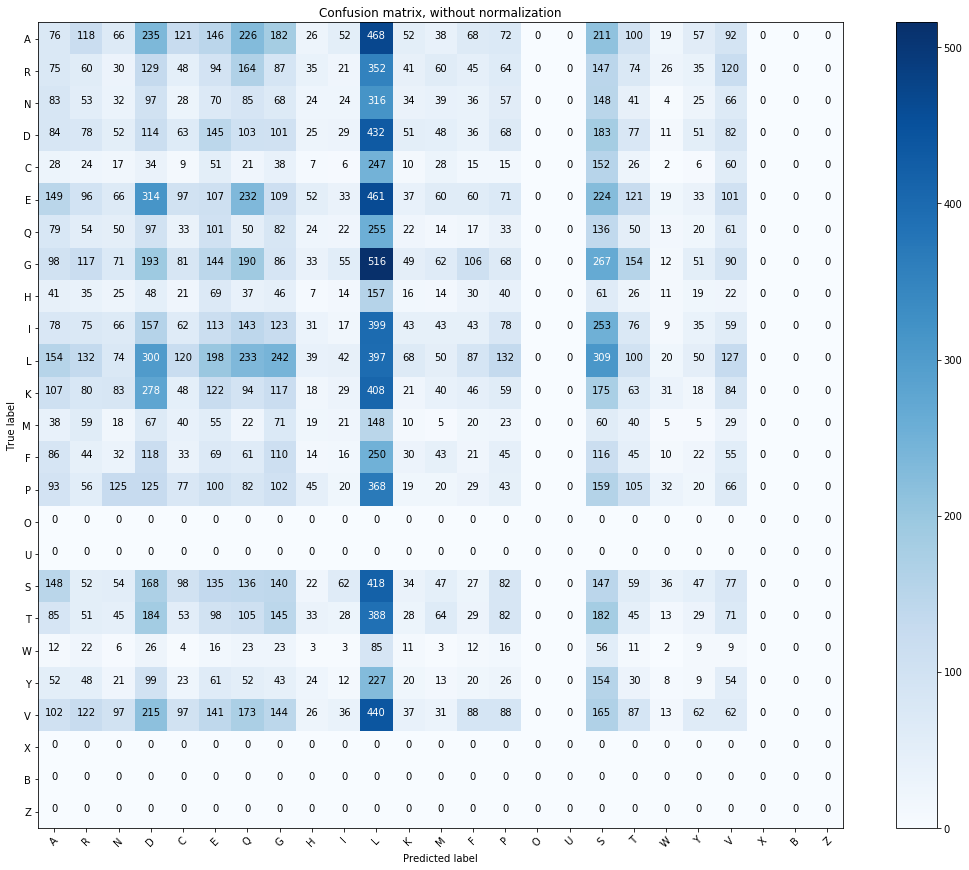

In [5]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
#     print(cm.shape)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=list(range(25)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()


### Plot Accuracy

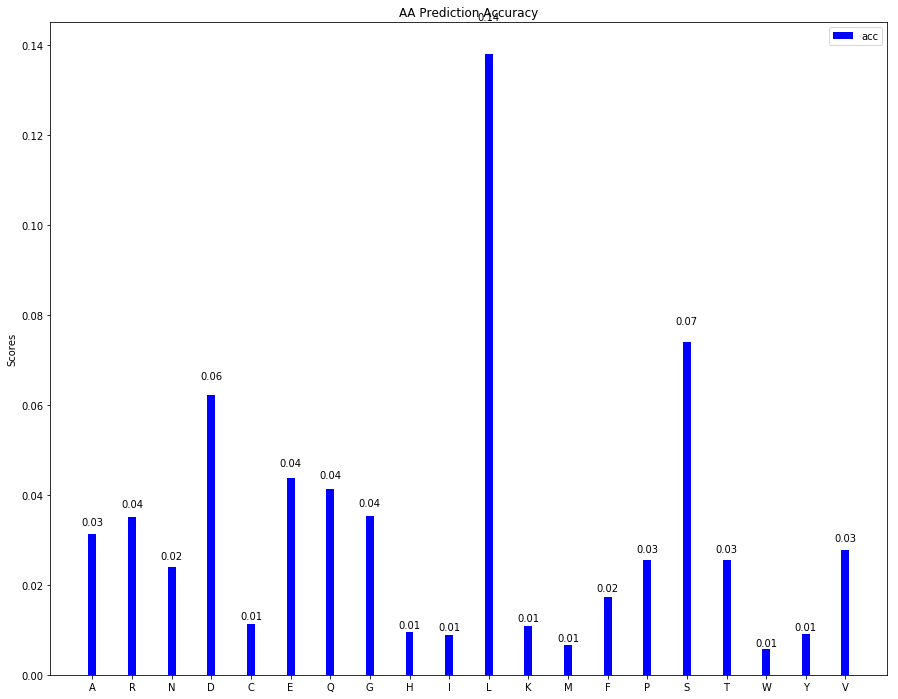

In [6]:
###https://matplotlib.org/examples/api/barchart_demo.html
def plot_accuracy(title, scores):
    
    N = len(scores)
    acc = list(scores.values())

    ind = np.arange(N)  # the x locations for the groups
    width = 0.2       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, acc, width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(list(scores.keys()))

    ax.legend((rects1,), ('acc',))
    
    autolabel(rects1, ax)


def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height,
                ha='center', va='bottom')
        
        
        
indx = [i for i, row in enumerate(cnf_matrix) if row[i] > 0]
acc_scores =  {reverse_dictionary[i]:cnf_matrix[i, i]/np.sum(row) 
               for i, row in enumerate(cnf_matrix) if i in indx}

plot_accuracy("AA Prediction Accuracy", acc_scores)
plt.show()

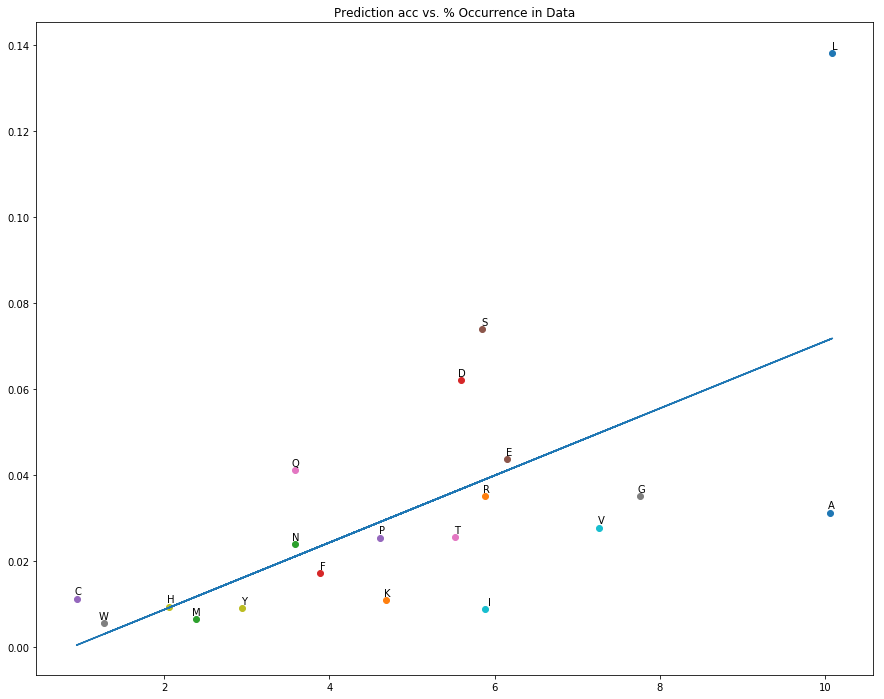

In [7]:
import pandas as pd

aa_feat = pd.read_csv('Data/aa_feat.csv')

x = aa_feat["Occurrence.in.Bacteria.proteins....."][indx]

y = list(acc_scores.values())

labels = [reverse_dictionary[i] for i in indx]


def plot(x, y, labels, title):
    xy = list(zip(x, y))
    for i, label in enumerate(labels):
        x, y = xy[i]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right', va='bottom')
        plt.title(title)

        
plot(x, y, labels, "Prediction acc vs. % Occurrence in Data")
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-')